<a href="https://colab.research.google.com/github/rpizarrog/analitica_de_datos/blob/main/python/Caso_02_Cargar_datos_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivo

Transformar y analizar datos provenientes de un archivo en formato EXCEL



# Descripción

... Mismas condiciones que el caso 01 anerior ...

* Identificar una ruta en donde se encuentra un archivo en formato CSV que define dos variables de interés, edades y generos Masculino o Femenino.
* Se cargan las funciones adecuadas.
* Se cargan las librerías.
* Se identifican datos sucios en el conjunto de datos.
* Se transforman los datos de la variable edades de la siguiente manera:
  * La variable se convierte a numérico y aquel que no sea número se le pone la etiqueta NaN.
  * Se convierte a valores absolutos.
  * Al calcular la mediana se modifican los valores NaN a valor de la mediana
  * Con el diagrama de caja se identifican datos atípicos.
  * Se observa histograma de las edades
* Se transorma la variable generos:
  * Convertir todos los valores a mayúsculas para estandarizar
  * Los registros que no tengan valor poner la moda de los valores.
  * Si hay un parecido en el string poner lo que se le parezca.

# Desarrollo



## Cargar librerías



In [ ]:
# !pip install fuzzywuzzy # Solo descargar una sola vez
# !pip install ipywidgets  # Solo una vez para permitir complementos o elementos interactivos


In [41]:
import pandas as pd
import numpy as np
from collections import Counter as Counter
import math

import matplotlib.pyplot as plt # Para visualizar datos

from fuzzywuzzy import process # Para modificar valores similares

from IPython.display import display, clear_output
import io
import ipywidgets as widgets


## Cargar funciones





In [42]:
datos_sucios = None  # Esta variable almacenará el DataFrame una vez cargado

def f_cargar_datos(uploader):
    if uploader.value:
        # Extraer la información del archivo cargado
        input_file = next(iter(uploader.value))
        content = uploader.value[input_file]['content']
        # Leer el contenido en un DataFrame
        df = pd.read_excel(io.BytesIO(content))
        return df
    else:
        return None

def on_cargar_clicked(b):
    global datos_sucios  # Indica que vamos a modificar la variable global
    if uploader.value:
        input_file = next(iter(uploader.value))
        content = uploader.value[input_file]['content']
        datos_sucios = pd.read_excel(io.BytesIO(content))  # Actualiza la variable global
        clear_output(wait=True)
        display(uploader, boton_cargar)
        print("Datos cargados correctamente. Puedes proceder a manipularlos.")
    else:
        print("Por favor, carga un archivo antes de hacer clic en 'Cargar datos'.")


# Definir la función que convierte una lista o arreglo a valores numéricos
def f_convertir_numeros(valores):
    # Convertir los valores a numéricos, forzando los no convertibles a NaN
    numericos = pd.to_numeric(valores, errors='coerce')
    return numericos

# Definen una función que convierte valores numéricos a valores absolutos
def f_convertir_absoluto (valores):
  return np.abs(valores)

# Función median con pandas la función median()
def f_mediana(valores):
  # Mediana excluyendo
  mediana = valores.median()
  return mediana

def f_convertir_mediana(valores):
    # Convertir la entrada a una Serie de Pandas si no lo es
    if not isinstance(valores, pd.Series):
        valores = pd.Series(valores)

    # Convertir todos los valores a numéricos, forzando los no convertibles a NaN
    valores_numericos = pd.to_numeric(valores, errors='coerce')

    # Calcular la mediana de los valores numéricos, excluyendo los NaN
    mediana = valores_numericos.median()

    # Reemplazar los NaN con la mediana
    numeros = valores_numericos.fillna(mediana)

    return numeros


# Función que visualiza histogrma de una variable de interés numérica
def f_histograma(numeros, contexto):
  # Calular l media
  media = np.mean(numeros)
  # Calcular la mediana
  mediana = np.median(numeros)

  desviacion_estandar = np.std(numeros, ddof=1)
  plt.hist(numeros, bins=8, edgecolor='k', alpha=0.7)
  plt.axvline(media, color='red', linestyle='dashed', linewidth=2, label=f'Media = {media:.2f}')
  plt.axvline(mediana, color='blue', linestyle='dashed', linewidth=2, label=f'Mediana = {mediana:.2f}')
  plt.axvline(media - desviacion_estandar, color='green', linestyle='dashed', linewidth=2, label=f'Desv. Estándar = {desviacion_estandar:.2f}')
  plt.axvline(media + desviacion_estandar, color='green', linestyle='dashed', linewidth=2)
  plt.title('Histograma de ' + contexto + ' con media y desviación estándar')
  plt.xlabel(contexto)
  plt.ylabel('Frecuencia')
  plt.legend()
  plt.show()

# Función que determina cuartiles
def f_cuartiles_quantile(datos):
  q1 = np.percentile(datos, 25)
  q2 = np.percentile(datos, 50)
  q3 = np.percentile(datos, 75)
  return q1, q2, q3

# Función que construye diagrama de caja
def f_diagrama_caja (datos, contexto):
  plt.boxplot(datos, vert=False)
  plt.xlabel(contexto)
  plt.ylabel('Valor')
  plt.title('Diagrama de Caja')

  # Calculando cuartiles d ela funci´pn previamente creada
  q1, q2, q3= f_cuartiles_quantile(datos)
  # Añadir leyendas para los cuartiles
  plt.axvline(x=q1, color='blue', linestyle='--', linewidth=1, label=f'Q1: {q1:.2f}')
  plt.axvline(x=q2, color='blue', linestyle='--', linewidth=1, label=f'Q2:Mediana: {q2:.2f}')
  plt.axvline(x=q3, color='blue', linestyle='--', linewidth=1, label=f'Q3: {q3:.2f}')

  # Añadir leyenda adicional
  plt.legend()

  plt.show()

def f_modificar_atipicos (datos):

  datos = np.array(datos)
  q1, q2, q3 = f_cuartiles_quantile(datos)

  # La mediana
  mediana = np.median(datos)

  # Rango Intercuartílico RI = q3 - q1
  RI = q3 - q1

  # Definir los límites para los valores atípicos
  limite_inferior = q1 - 1.5 * RI
  limite_superior = q3 + 1.5 * RI

  # Calcular la mediana
  mediana = np.median(datos)

  # Reemplazar los valores atípicos por la mediana
  datos[(datos < limite_inferior) | (datos > limite_superior)] = mediana

  return datos


# Convertir todos los valores a mayúsculas para estandarizar la columna.
def f_convertir_MAYUSCULAS(valores):
  # 1. Convertir todos los valores a mayúsculas
  valores = valores.str.upper()
  return valores

def f_reemplazar_generos_moda (valores):
  moda_generos = valores.mode()[0]

  valores.fillna(moda_generos, inplace=True)

  return valores

# Función que debe modifiar un valor de acuerdo a la cadena que mas se le parezca
def f_modificar_inicial (valores):
  # Mapear cualquier valor que sea claramente 'M' o 'F' a 'MASCULINO' o 'FEMENINO'
  valores = valores.replace({'M': 'MASCULINO', 'F': 'FEMENINO'})

  # Debe identificar los valores únicos los dos que mas se repitan
  # por ejemplo FEMENINO Y MASCULINO
  # De cada valor si hay una ler F es FEMENINO
  # De cada valor si hay una ler M es MASCULINO
  # De cada valor si se parece por ejemplo GEMENINO se parece a FEMENINO
  # De cada valor si se parece por ejemplo SASCULINO se parece a MASCULINO
  return valores

# Visualiza diagrama de barra de una variable categórica
def f_diagrama_barra(valores, contexto):
  # Contar la frecuencia de cada categoría en la columna 'generos'
  frecuencias = valores.value_counts()

  # Crear el diagrama de barras
  frecuencias.plot(kind='bar')

  # Agregar etiquetas y título para mayor claridad
  plt.xlabel(contexto)
  plt.ylabel('Frecuencia')
  plt.title('Frecuencia' + contexto)
  plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad

  # Mostrar leyenda
  plt.legend(['Frecuencia'])
  # Anotar cada barra con su respectiva frecuencia
  for index, value in enumerate(frecuencias):
    plt.text(index, value, str(value), ha='center', va='bottom')

  # Mostrar el diagrama
  plt.show()

# Función que modifica valores similares
def f_modificar_parecidos(valores, opciones=['FEMENINO', 'MASCULINO'], umbral=50):
    """
    Estandariza los valores de género en una lista o columna de DataFrame a 'FEMENINO' o 'MASCULINO' basado en la similitud.

    Parámetros:
    - valores: Una lista o Serie de pandas con los valores de género a estandarizar.
    - opciones: Una lista de valores aceptados a los que se intentará hacer coincidir los valores.
    - umbral: El umbral de coincidencia para considerar una equivalencia (0-100).

    Retorna:
    Una lista o Serie de pandas con los valores estandarizados.
    """
    # Función para estandarizar un único valor
    def estandarizar_valor(valor):
        if valor is None:  # Verifica si el valor es None antes de proceder
            return valor
        mejor_coincidencia, puntaje = process.extractOne(valor.upper(), opciones)
        return mejor_coincidencia if puntaje > umbral else valor

    # Aplicar la estandarización a cada valor en la lista o Serie
    if isinstance(valores, pd.Series):
        return valores.apply(estandarizar_valor)
    else:
        return [estandarizar_valor(valor) for valor in valores]

# Funci´n que recibe los datos
# Por cada columna limpia los valores
def f_transformar_datos(datos_sucios):
  # pendiente
  return datos_limpios

## Variables globales


In [36]:
# datos_sucios = None  # Esta variable almacenará el DataFrame una vez cargado

## Cargar datos



In [47]:
# Crear el widget de carga
uploader = widgets.FileUpload(
    accept='.xlsx',  # Aceptar solo archivos .xlsx
    multiple=False  # Permitir la carga de un solo archivo
)

# Crear un botón para procesar el archivo después de cargarlo
boton_cargar = widgets.Button(description="Cargar datos")

# Asignar la acción al botón
datos_sucios = boton_cargar.on_click(on_cargar_clicked)

print ("Datos Sucios")
# Mostrar el widget de carga y el botón
display(uploader, boton_cargar)


FileUpload(value={'datos_estudiantes_sucios.xlsx': {'metadata': {'name': 'datos_estudiantes_sucios.xlsx', 'typ…

Button(description='Cargar datos', style=ButtonStyle())

Datos cargados correctamente. Puedes proceder a manipularlos.


## Transformar datos

### Columna edades


    edades    generos
0     13.0   Femenino
1     25.5  Masculino
2     25.0  Masculino
3     29.0        NaN
4     13.0  Masculino
5      8.0        NaN
6     11.0  Masculino
7     42.0   FEMENINO
8      9.0   Femenino
9     13.0  Masculino
10    33.0   Femenino
11    19.0  Masculino
12    27.0  Masculino
13     9.0  Masculino
14    49.0          M
15    25.5   FEMENINO
16    22.0   FEMENINO
17     1.0   FEMENINO
18    47.0  Masculino
19    11.0   FEMENINO
20    33.0  Masculino
21    14.0  Masculino
22    38.0  Masculino
23    16.0   Femenino
24    48.0   Femenino
25    31.0   Femenino
26    17.0   FEMENINO
27    49.0   Femenino
28     5.0   Femenino
29     4.0   oasculno
30    36.0  Masculino
31    40.0   FEMENINO
32    33.0  Masculino
33    44.0          F
34    41.0    FMENINO
35    46.0  Masculino
36     8.0    MESCLIN
37    26.0   FEMENINO
38    40.0  Masculino
39     4.0   FEMENINO
40    10.0   FEMENINO
41     2.0   Mascuino
42    28.0   GAMENINO
43    25.5  Masculino
44     7.0

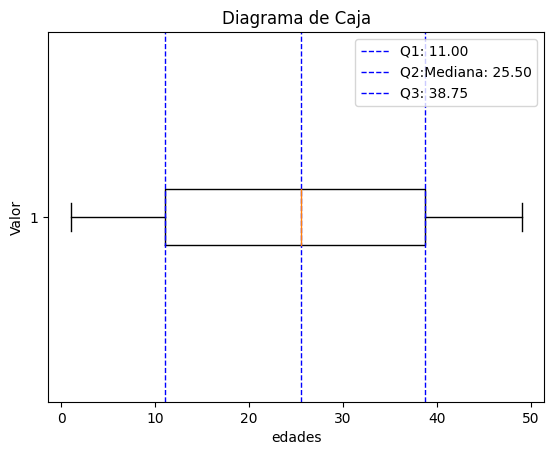

Datos Limpios Finales
    edades    generos
0     13.0   Femenino
1     25.5  Masculino
2     25.0  Masculino
3     29.0        NaN
4     13.0  Masculino
5      8.0        NaN
6     11.0  Masculino
7     42.0   FEMENINO
8      9.0   Femenino
9     13.0  Masculino
10    33.0   Femenino
11    19.0  Masculino
12    27.0  Masculino
13     9.0  Masculino
14    49.0          M
15    25.5   FEMENINO
16    22.0   FEMENINO
17     1.0   FEMENINO
18    47.0  Masculino
19    11.0   FEMENINO
20    33.0  Masculino
21    14.0  Masculino
22    38.0  Masculino
23    16.0   Femenino
24    48.0   Femenino
25    31.0   Femenino
26    17.0   FEMENINO
27    49.0   Femenino
28     5.0   Femenino
29     4.0   oasculno
30    36.0  Masculino
31    40.0   FEMENINO
32    33.0  Masculino
33    44.0          F
34    41.0    FMENINO
35    46.0  Masculino
36     8.0    MESCLIN
37    26.0   FEMENINO
38    40.0  Masculino
39     4.0   FEMENINO
40    10.0   FEMENINO
41     2.0   Mascuino
42    28.0   GAMENINO
43    25.5

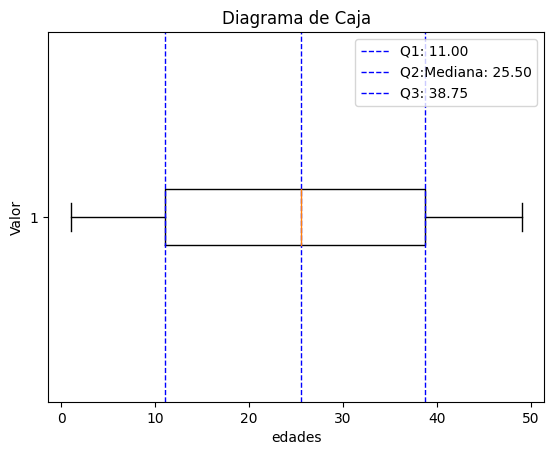

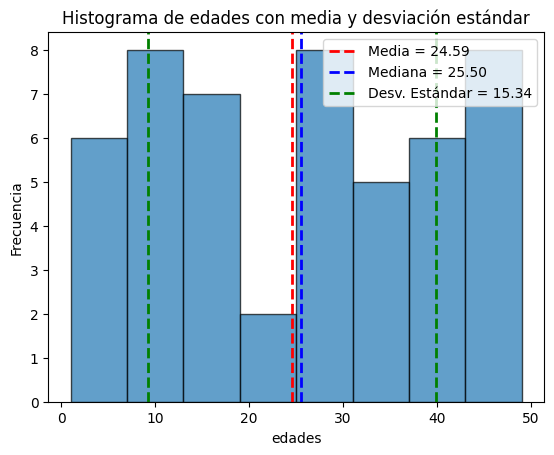

    edades    generos
0     13.0   Femenino
1     25.5  Masculino
2     25.0  Masculino
3     29.0        NaN
4     13.0  Masculino
5      8.0        NaN
6     11.0  Masculino
7     42.0   FEMENINO
8      9.0   Femenino
9     13.0  Masculino
10    33.0   Femenino
11    19.0  Masculino
12    27.0  Masculino
13     9.0  Masculino
14    49.0          M
15    25.5   FEMENINO
16    22.0   FEMENINO
17     1.0   FEMENINO
18    47.0  Masculino
19    11.0   FEMENINO
20    33.0  Masculino
21    14.0  Masculino
22    38.0  Masculino
23    16.0   Femenino
24    48.0   Femenino
25    31.0   Femenino
26    17.0   FEMENINO
27    49.0   Femenino
28     5.0   Femenino
29     4.0   oasculno
30    36.0  Masculino
31    40.0   FEMENINO
32    33.0  Masculino
33    44.0          F
34    41.0    FMENINO
35    46.0  Masculino
36     8.0    MESCLIN
37    26.0   FEMENINO
38    40.0  Masculino
39     4.0   FEMENINO
40    10.0   FEMENINO
41     2.0   Mascuino
42    28.0   GAMENINO
43    25.5  Masculino
44     7.0

In [51]:
datos_limpios = datos_sucios

print (datos_sucios)
datos_limpios['edades'] = f_convertir_numeros(datos_limpios['edades'])
datos_limpios['edades'] = f_convertir_absoluto(datos_limpios['edades'])
datos_limpios['edades'] = f_convertir_mediana(datos_limpios['edades'])
f_diagrama_caja(datos_limpios['edades'], 'edades')
datos_limpios['edades'] = f_modificar_atipicos(datos_limpios['edades'])
print ("Datos Limpios Finales")
print (datos_limpios)

# Verificar si se modifiacron os datos atípicos
f_diagrama_caja(datos_limpios['edades'], 'edades')
f_histograma(datos_limpios['edades'], 'edades')
print (datos_limpios)


### Limpiar generos


In [52]:
datos_limpios['generos'] = f_convertir_MAYUSCULAS(datos_limpios['generos'])
datos_limpios['generos'] = f_reemplazar_generos_moda(datos_limpios['generos'])
datos_limpios['generos'] = f_modificar_inicial(datos_limpios['generos'])
datos_limpios['generos'] = f_modificar_parecidos(datos_limpios['generos'])
print ("Finalmente datos limpios")
print (datos_limpios)


Finalmente datos limpios
    edades    generos
0     13.0   FEMENINO
1     25.5  MASCULINO
2     25.0  MASCULINO
3     29.0   FEMENINO
4     13.0  MASCULINO
5      8.0   FEMENINO
6     11.0  MASCULINO
7     42.0   FEMENINO
8      9.0   FEMENINO
9     13.0  MASCULINO
10    33.0   FEMENINO
11    19.0  MASCULINO
12    27.0  MASCULINO
13     9.0  MASCULINO
14    49.0  MASCULINO
15    25.5   FEMENINO
16    22.0   FEMENINO
17     1.0   FEMENINO
18    47.0  MASCULINO
19    11.0   FEMENINO
20    33.0  MASCULINO
21    14.0  MASCULINO
22    38.0  MASCULINO
23    16.0   FEMENINO
24    48.0   FEMENINO
25    31.0   FEMENINO
26    17.0   FEMENINO
27    49.0   FEMENINO
28     5.0   FEMENINO
29     4.0  MASCULINO
30    36.0  MASCULINO
31    40.0   FEMENINO
32    33.0  MASCULINO
33    44.0   FEMENINO
34    41.0   FEMENINO
35    46.0  MASCULINO
36     8.0  MASCULINO
37    26.0   FEMENINO
38    40.0  MASCULINO
39     4.0   FEMENINO
40    10.0   FEMENINO
41     2.0  MASCULINO
42    28.0   FEMENINO
43    2

# Interpretación